### Train XGBoost

In [8]:
import pandas as pd
from utils.constants import *
from sklearn.model_selection import KFold, StratifiedShuffleSplit,ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn import ensemble, svm, tree, linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler, QuantileTransformer, RobustScaler, PowerTransformer
from sklearn.metrics import root_mean_squared_error,root_mean_squared_log_error, r2_score, median_absolute_error,mean_absolute_percentage_error,mean_absolute_error, max_error
import xgboost as xgb
# REF: SCALERS -- https://medium.com/@daython3/scaling-your-data-using-scikit-learn-scalers-3d4b584107d7
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import pickle

In [9]:
from sklearn.preprocessing import LabelEncoder
file_name = r'model_assets/xgb_SimpleImputers_OutliersRemoved_NoVehCond.pkl'

In [10]:
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv', 'dereg_value', 'car_age', 'depreciation', 'arf','coe', 'road_tax',
       'engine_cap',  'mileage', 'no_of_owners', 
            # 'cond_vehicle_type_0',	'cond_vehicle_type_1',	'cond_vehicle_type_2',	
            # 'cond_vehicle_type_3',	'cond_vehicle_type_4',
            'type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck',
        'coe car', 'parf car', 
       'rare & exotic', 'emission_data']

In [11]:
best_xgb = pickle.load(open(file_name, "rb"))

name = 'SimpleImputers_OutliersRemoved_NoVehCond'
train_dir = rf'./processed_dataset/train_{name}.csv'
val_dir = rf'./processed_dataset/val_{name}.csv'
test_dir = rf'./processed_dataset/test_{name}.csv'

train_df = pd.read_csv(train_dir)
val_df = pd.read_csv(val_dir)
test_df = pd.read_csv(test_dir)

In [12]:
X_train = train_df[features].values
y_train = train_df['price'].values
print(X_train, y_train)
X_val = val_df[features].values
y_val = val_df['price'].values

X_test= test_df[features].values


[[ 2.09663211 -0.1385766  -0.06607423 ...  0.          0.
   0.01007253]
 [-2.04729548 -1.38765697 -0.06607423 ...  0.          0.
   0.01007253]
 [-0.56265794 -1.14214638 -0.06607423 ...  1.          0.
   0.01007253]
 ...
 [-1.81891371 -1.38765697 -0.06607423 ...  1.          0.
  -2.12900016]
 [ 0.1177062   2.11315643  2.36428654 ...  1.          1.
   2.74985992]
 [ 0.78927192  1.30063791 -0.06607423 ...  0.          0.
   0.01007253]] [ 89800.    700.  64800. ...  73800. 649900.  53888.]


In [13]:
# Predict on the training and holdout sets
y_train_pred = best_xgb.predict(X_train)
y_val_pred = best_xgb.predict(X_val)

# Calculate metrics
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_max_error = max_error(y_train, y_train_pred)

holdout_rmse = root_mean_squared_error(y_val, y_val_pred)
holdout_r2 = r2_score(y_val, y_val_pred)
holdout_mae = mean_absolute_error(y_val, y_val_pred)
holdout_max_error = max_error(y_val, y_val_pred)
holdout_mape = mean_absolute_percentage_error(y_val, y_val_pred)

# Print metrics to compare
print(f"train_rmse: {train_rmse}")
print(f"train_mae: {train_mae}")
print(f"train_max_error: {train_max_error}")

print(f"holdout_rmse: {holdout_rmse}")
print(f"holdout_r2: {holdout_r2}")
print(f"holdout_mae: {holdout_mae}")
print(f"holdout_max_error: {holdout_max_error}")
print(f"holdout_mape: {holdout_mape}")


train_rmse: 7454.020503336121
train_mae: 4702.595922363281
train_max_error: 115196.75
holdout_rmse: 25304.81806112328
holdout_r2: 0.9689149414139245
holdout_mae: 7059.348194140625
holdout_max_error: 1095405.0078125
holdout_mape: 0.07426617417651764


### Combine dataset for training

In [14]:
combined_df = pd.concat([train_df, val_df], ignore_index=True)

In [15]:
x_combined_train = combined_df[features].values
y_combined_train = combined_df['price'].values


In [16]:
xgb_reg = xgb.XGBRegressor(subsample=0.6, reg_lambda=1.5, reg_alpha=1, n_estimators=500, max_depth=5, learning_rate=0.1, colsample_bytree= 1.0, random_state=42)


In [17]:
xgb_reg.fit(x_combined_train, y_combined_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [18]:
name = "SimpleImputers_OutliersRemoved_NoVehCond"

In [19]:
pickle.dump(xgb_reg, open(rf"C:/Users/kan_h/Desktop/Kan Hon/Admin/NUS MComp/AY2425_Sem1/CS5228/cs5228-project/CS5228_project/model_assets/xgb_{name}_combined.pkl", "wb"))


In [20]:
y_test = xgb_reg.predict(X_test)


In [21]:
test_df['Predicted'] = y_test


In [22]:
test_df['id'] = test_df.index
test_df.Predicted = test_df.Predicted.apply(lambda x:round(x / 100.0) * 100.0)
submission = test_df[['id','Predicted']]
submission.head()

,id,Predicted
0,0,19700.0
1,1,36300.0
2,2,144900.0
3,3,79200.0
4,4,26300.0


In [23]:
submission.to_csv(rf'./submission/submission-{name}-xgb-train-val-combined.csv',index=False)


### SHAP

In [24]:
import shap

C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
explainer = shap.TreeExplainer(best_xgb)


In [26]:
shap_values = explainer.shap_values(X_val)

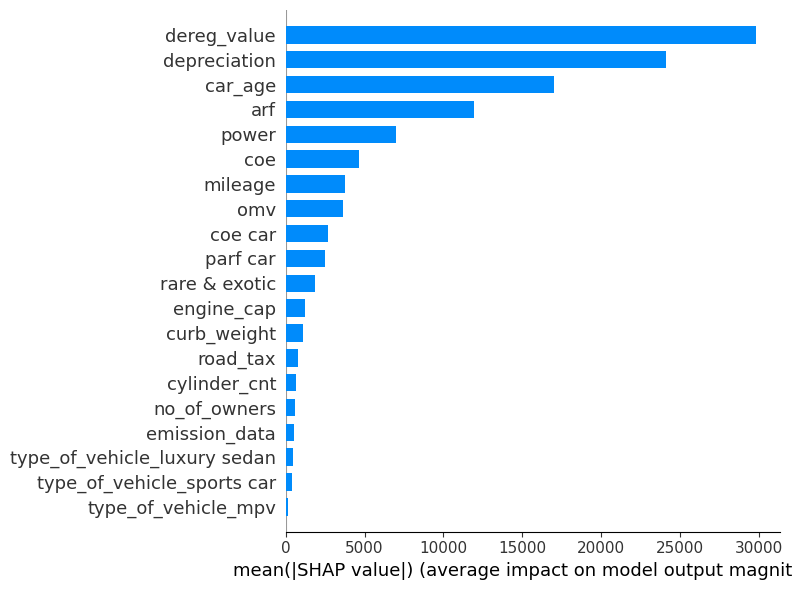

In [27]:
shap.summary_plot(shap_values, X_val, plot_type="bar", feature_names=features, plot_size=[8,6])


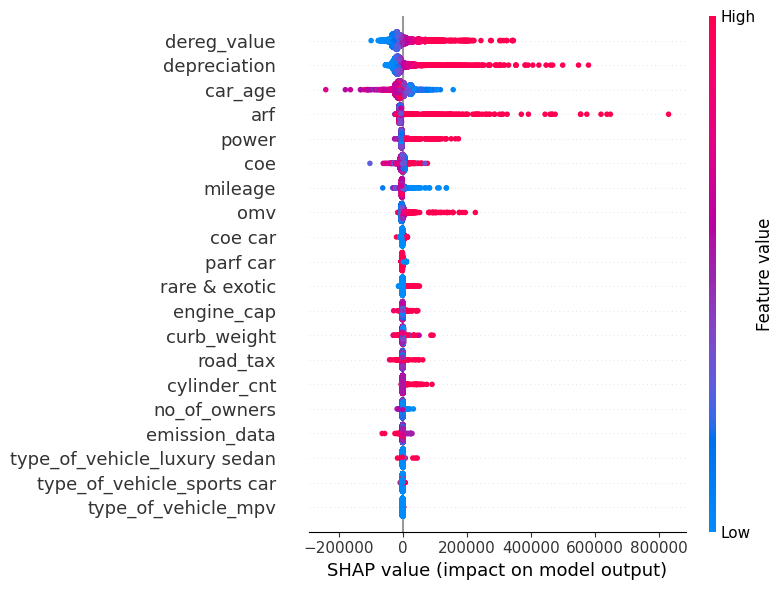

In [28]:
shap.summary_plot(shap_values, X_val, feature_names=features, plot_size=[8,6])


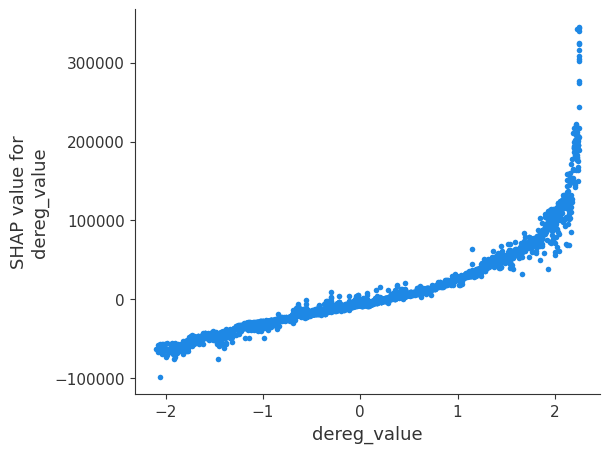

In [32]:
shap.dependence_plot('dereg_value', shap_values, X_val, feature_names=features, interaction_index=None)


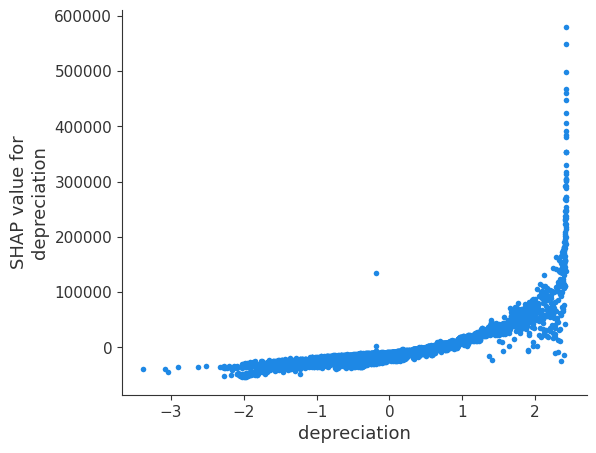

In [33]:
shap.dependence_plot('depreciation', shap_values, X_val, feature_names=features, interaction_index=None)


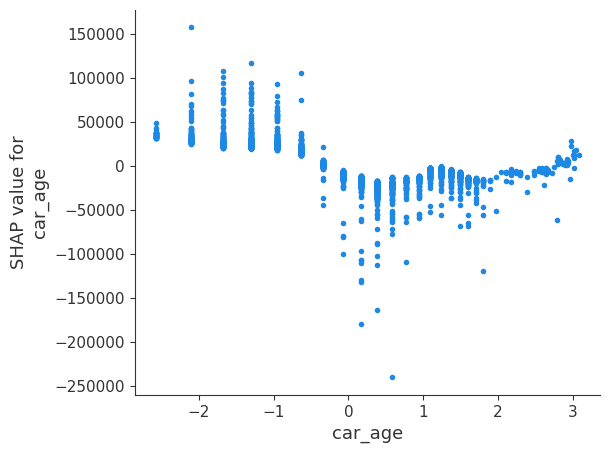

In [45]:
shap.dependence_plot('car_age', shap_values, X_val, feature_names=features, interaction_index=None)


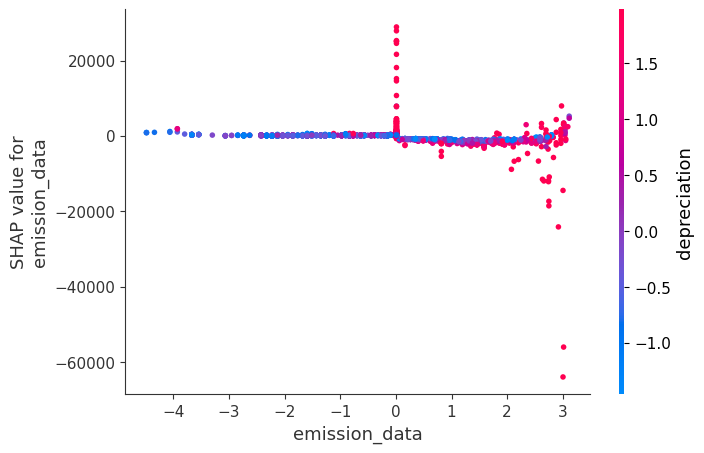

In [31]:
shap.dependence_plot('emission_data', shap_values, X_val, feature_names=features, interaction_index='auto')


### LIME

In [34]:
pd.options.display.max_columns = None
import numpy as np
import lime
from lime.lime_tabular import LimeTabularExplainer

In [35]:
abs_diff = np.abs(y_val - y_val_pred)
topk = 5
max_diff_index = np.argpartition(abs_diff,-topk)[-topk:]
max_diff_index, abs_diff[max_diff_index]

(array([4186,  812, 3130, 4036, 1278], dtype=int64),
 array([ 387991.8125   ,  412475.25     ,  454026.5      ,  458329.75     ,
        1095405.0078125]))

In [38]:
j = 1278

In [39]:
y_val_pred[j]

104594.99

In [40]:
val_df.iloc[[j]]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price,reg_date_dt,reg_date_year,reg_date_month,model_make,coe_age_left,age_range,car_age,type_of_vehicle_bus/mini bus,type_of_vehicle_hatchback,type_of_vehicle_luxury sedan,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,fuel_type_diesel,fuel_type_diesel-electric,fuel_type_electric,fuel_type_petrol,fuel_type_petrol-electric,fuel_type_nan,cylinder_cnt,-,almost new car,coe car,consignment car,direct owner sale,electric cars,hybrid cars,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars,emission_data
1278,1158559.0,Lotus 340R (COE till 11/2025),lotus,340r,limited edition lotus 340r. only 1 in singapor...,-2.218855,25-jan-2003,01-dec-2005,sports car,"imported used vehicle, coe car",0.0,-4.091692,0.388444,NaN,-0.055748,3.0,0.560852,0.767413,0.600322,-0.420694,1.095599,1.281745,1.154455,NaN,NaN,uncategorized,NaN,NaN,NaN,1200000.0,2005-12-01,2005.0,12.0,340r_lotus,0.0,1.0,2.175917,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.066074,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.010073


In [41]:

# Initialize the explainer
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=features,
    mode='regression'  # Set to 'regression' for regression models
)



In [42]:
# Choose an instance to explain (e.g., first instance in the test set)

instance = X_val[j]

explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=best_xgb.predict  # Use predict for regression
)
# Display the explanation 
explanation.show_in_notebook(show_table=True, show_all=False)

In [43]:
val_df.iloc[[j]]

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price,reg_date_dt,reg_date_year,reg_date_month,model_make,coe_age_left,age_range,car_age,type_of_vehicle_bus/mini bus,type_of_vehicle_hatchback,type_of_vehicle_luxury sedan,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,fuel_type_diesel,fuel_type_diesel-electric,fuel_type_electric,fuel_type_petrol,fuel_type_petrol-electric,fuel_type_nan,cylinder_cnt,-,almost new car,coe car,consignment car,direct owner sale,electric cars,hybrid cars,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars,emission_data
1278,1158559.0,Lotus 340R (COE till 11/2025),lotus,340r,limited edition lotus 340r. only 1 in singapor...,-2.218855,25-jan-2003,01-dec-2005,sports car,"imported used vehicle, coe car",0.0,-4.091692,0.388444,NaN,-0.055748,3.0,0.560852,0.767413,0.600322,-0.420694,1.095599,1.281745,1.154455,NaN,NaN,uncategorized,NaN,NaN,NaN,1200000.0,2005-12-01,2005.0,12.0,340r_lotus,0.0,1.0,2.175917,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.066074,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.010073
